In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train_dataset = torchvision.datasets.CIFAR10('temp', train=True, transform=transform, download=False)

In [5]:
test_dataset = torchvision.datasets.CIFAR10('temp', train=False, transform=transform, download=False)

In [6]:
len(train_dataset),len(test_dataset)

(50000, 10000)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=2, shuffle=False)

In [8]:
train_iter = iter(train_loader)
imgs, labels = train_iter.next()
imgs.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [9]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

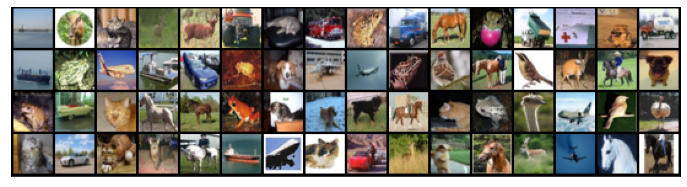

In [10]:
show_batch(train_loader)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [13]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([64, 3, 32, 32])
out.shape: torch.Size([64, 8, 16, 16])


In [14]:
class Cifar10CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential( #input image size: 3 x 32 x 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [15]:
model = Cifar10CnnModel().to(device)

In [16]:
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [18]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 32, 32])
out.shape: torch.Size([64, 10])
out[0]: tensor([ 0.0309,  0.0350, -0.0064,  0.0233, -0.0501,  0.0400, -0.0196,  0.0093,
         0.0274,  0.0207], grad_fn=<SelectBackward>)


In [19]:
num_epochs = 2
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        out = model(imgs)
        loss = criterion(out, labels)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        if (i+1)%50 == 0:
            print(f'Epoch : {epoch+1}/{num_epochs}, Step : {i+1}/{len(train_loader)}, Loss : {loss.item():.4f}')

print('Finished Training')

KeyboardInterrupt: 

In [20]:
n_samples = 0
n_correct = 0
with torch.no_grad():
    
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outs = model(images)
        
        _, pred = torch.max(outs.data, 1)
        
        n_samples += labels.size(0) # total sample size, gets loaded in batches
        n_correct += (pred == labels).sum().item()  
    
    acc = 100*(n_correct/n_samples)
    print(f'n_correct : {n_correct}, n_samples : {n_samples}, accuracy : {acc} %')

In [27]:
model = torch.load('cifar10_cpu.pth')
model

    ...,
              
                       [[ 2.2618e-02,  6.5066e-03,  3.3657e-03],
                        [-7.5992e-03, -2.2076e-02,  3.2269e-03],
                        [-1.4751e-02, -3.1243e-03,  4.4889e-05]],
              
                       [[-1.2936e-02, -2.8586e-03, -1.5292e-02],
                        [-1.3048e-02,  1.2344e-02, -6.9250e-03],
                        [-1.6402e-02, -1.5333e-02,  3.3807e-03]],
              
                       [[ 3.6190e-03,  2.1037e-02, -4.5867e-03],
                        [ 1.7200e-03,  1.2782e-03,  8.6463e-03],
                        [ 1.4973e-02, -2.2493e-02,  9.1243e-03]]],
              
              
                      [[[ 1.2760e-02, -1.1794e-02,  9.5611e-03],
                        [ 6.9911e-03,  1.0367e-02, -7.7819e-03],
                        [-1.0244e-02, -6.8545e-03,  3.4481e-04]],
              
                       [[ 3.0354e-03,  1.1850e-02,  2.5936e-02],
                        [ 2.9018e-03,  4.7061e-02, 

In [24]:
map_location=torch.device('cpu')

In [ ]:
model.fc.